In [6]:
import pandas as pd
import numpy as np
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, strip_numeric, strip_punctuation, strip_short, stem_text
import matplotlib.pyplot as plt

path = '../Files/'

# Preliminary Analysis

In [4]:
# Load processed data
proc_df = pd.read_csv(path+'processed_data.csv')
# Load predictions
relevant_cols = ["PERMID", "CIK", "Ticker", "year", "FilingDate", "company_name", "Dividend Payer", "DPS growth", "DPS cut", "zEnvironmental", "dEnvironmental", "sector"]
pred_df = pd.read_excel(path + "predictions.xlsx", sheet_name="data", skiprows=32, usecols=relevant_cols)
pred_df.columns = ["perm_id", "cik", "ticker", "year", "filing_date", "company_name", "is_dividend_payer", "dps_change", "is_dps_cut", "z_environmental", "d_environmental", "sector"]
pred_df['perm_id'] = pred_df['perm_id'].str.replace(r"[^0-9]",'')
pred_df["filing_date"] = pd.to_datetime(pred_df["filing_date"])
pred_df["filing_year"] = pd.DatetimeIndex(pred_df["filing_date"]).year

<ipython-input-4-e31754fa6c72>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_df['perm_id'] = pred_df['perm_id'].str.replace(r"[^0-9]",'')


In [5]:
proc_df

,Unnamed: 0,item1a_risk,item7_mda,year,filing_year_x,perm_id,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector,filing_year_y
0,0,> ITEM 1A. RISK FACTORS The following is a des...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2012,2012,4332,AAR CORP,1.0,0.000000,0.0,NaN,NaN,Industrials,2012
1,1,> ITEM 1A. RISK FACTORS In addition to the oth...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2012,2012,2991,ABBOTT LABORATORIES,1.0,-0.891775,1.0,0.469912,3.672476,Health Care,2013
2,2,>Item 1A. Risk factors You should carefully co...,>Item 7. Management s Discussion and Analysis ...,2012,2012,2883,ACETO CORP,1.0,0.095238,0.0,NaN,NaN,Industrials,2012
3,3,>ITEM 1A. RISK FACTORS The risks and uncertain...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2012,2012,3741,ADVANCED MICRO DEVICES,0.0,NaN,NaN,0.688089,0.849986,Tech,2013
4,4,> ITEM 1A. RISK FACTORS Our business and inves...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2012,2012,2791,BALLY TECHNOLOGIES INC,0.0,NaN,NaN,NaN,NaN,Tech,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20603,20603,>ITEM 1A.RISK FACTORSThis section describes ce...,>ITEM 7.MANAGEMENT S DISCUSSION AND ANALYSIS O...,2019,2019,1501,STERIS PLC,1.0,0.086331,0.0,1.303435,-0.051232,Health Care,2019
20604,20604,>ITEM 1A. RISK FACTORS An investment in our se...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2019,2019,1695,ONESPAWORLD HOLDINGS LTD,1.0,NaN,NaN,-1.706665,0.325100,Consumer,2020
20605,20605,>Item 1A. Risk Factors. You should carefully c...,>Item 7. Management s Discussion and Analysis ...,2019,2019,2093,CERENCE INC,0.0,NaN,NaN,-0.987200,1.077764,Tech,2019
20606,20606,>ITEM 1A.Risk Factors Risks Related to Our Bus...,>ITEM 7.Management s Discussion and Analysis o...,2019,2019,146,PIONEER BANCORP INC,0.0,NaN,NaN,NaN,NaN,Financials,2019


In [21]:
pred_df

,perm_id,cik,ticker,year,filing_date,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector,filing_year
0,229,1090872,A,2012,2012-12-20,AGILENT TECHNOLOGIES INC,1.0,0.421053,0.0,2.449925,-1.408006,Health Care,2012
1,229,1090872,A,2013,2013-12-19,AGILENT TECHNOLOGIES INC,1.0,0.137652,0.0,1.666993,1.117957,Health Care,2013
2,229,1090872,A,2014,2014-12-22,AGILENT TECHNOLOGIES INC,1.0,-0.275862,1.0,2.154238,-0.193752,Health Care,2014
3,229,1090872,A,2015,2015-12-21,AGILENT TECHNOLOGIES INC,1.0,0.139535,0.0,2.069083,0.039619,Health Care,2015
4,229,1090872,A,2016,2016-12-20,AGILENT TECHNOLOGIES INC,1.0,0.137652,0.0,2.087030,-0.112717,Health Care,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27030,3286,1011006,YHOO,2015,2016-02-29,ALTABA INC,0.0,NaN,NaN,-0.180481,-1.653875,Consumer,2016
27031,3286,1011006,YHOO,2016,2017-03-01,ALTABA INC,0.0,NaN,NaN,-0.836055,NaN,Consumer,2017
27032,2000,887568,ZOLL,2010,2010-12-17,ZOLL MEDICAL CORP,0.0,NaN,NaN,NaN,NaN,Health Care,2010
27033,2000,887568,ZOLL,2011,2011-11-23,ZOLL MEDICAL CORP,0.0,NaN,NaN,NaN,NaN,Health Care,2011


### Word occurences

In [141]:
def count_occurences(column, target, ratio=True):
    occurences = {}
    for year in range(2012, 2020):
        occurences[year] = proc_df[(proc_df.year == year)][column].str.count(target).sum()
        if ratio:
            total_count = proc_df[(proc_df.year == year)][column].str.count(' ').sum()
            occurences[year] /= total_count
    return occurences

def plot_occurences(target, title='', ratio=True):
    occ_7 = count_occurences('item7_mda', target, ratio)
    occ_1a = count_occurences('item1a_risk', target, ratio)

    plt.figure()
    plt.title(title)
    plt.plot(occ_1a.keys(), occ_1a.values(), label='Item 1A')
    plt.plot(occ_7.keys(), occ_7.values(), label='Item 7')
    plt.legend()

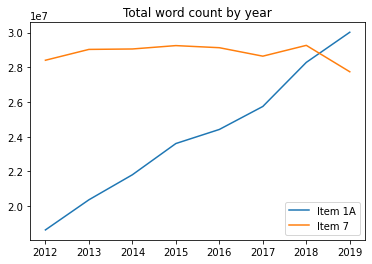

In [142]:
# Overall word count
plot_occurences(' ', 'Total word count by year', ratio=False)

There is a sharp increase in word count in Item 1A from year to year.

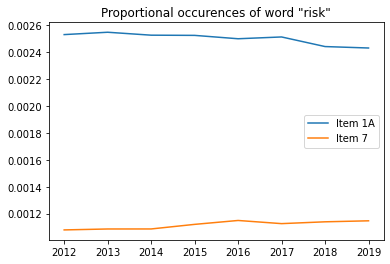

In [143]:
# Word 'risk'
plot_occurences('risk', 'Proportional occurences of word "risk"')

Item 1A seems to mention risk twice as frequently, which is expected

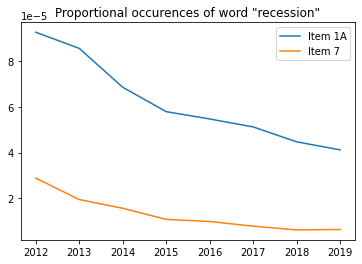

In [145]:
# Word 'recession'
plot_occurences('recession', 'Proportional occurences of word "recession"')

As expected, the recession is talked about less frequently the less recently it happened.

> Next will start looking at the relationship between occurence of a word and stock events.